## Reference Model

In [1]:
import maxentep
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
M = 4
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.04571012, 0.35085848, 0.21413484, 0.38929656],
        [0.19390869, 0.24358242, 0.24811675, 0.31439214],
        [0.34346919, 0.25386995, 0.08403657, 0.31862428],
        [0.10498426, 0.17986145, 0.36296637, 0.35218792]]),
 array([1., 1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(1.0, compartments)
tmat.add_norm_dist('E', 'A', 5, 2)
tmat.add_norm_dist('A', 'I', 3, 2)
tmat.add_norm_dist('I', 'R', 14, 4)
T = tmat.sample(1)[0]
T

array([[0.83951949, 0.16048051, 0.        , 0.        ],
       [0.        , 0.64884807, 0.35115193, 0.        ],
       [0.        , 0.        , 0.88052926, 0.11947074],
       [0.        , 0.        , 0.        , 1.        ]])

In [4]:
start = np.zeros((M, C))
start[0, 1] = 0.1

In [5]:
infect = maxentep.contact_infection_func(0.1,infections_compartments)
model = maxentep.MetaModel(start, R, T, infect)

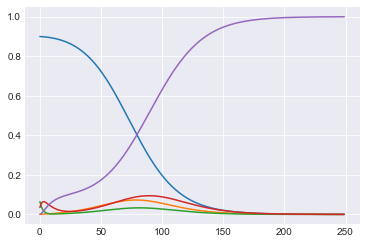

In [6]:
ref_traj = model.run(250)[0]
plt.plot(ref_traj[:,0])

## Sample SEIR Trajectories 

Use different compartment dist

In [7]:
# compartment parameters
compartments = ['E', 'I', 'R']
infections_compartments = [1]
C = len(compartments)
tmat = maxentep.TransitionMatrix(1.0, compartments)
tmat.add_norm_dist('E', 'I', 7, 2)
tmat.add_norm_dist('I', 'R', 11, 4)
T = tmat.sample(1)[0]
T

array([[0.79917062, 0.20082938, 0.        ],
       [0.        , 0.91826832, 0.08173168],
       [0.        , 0.        , 1.        ]])

In [8]:
def sample_rmat(N, loc=1.0):
    M = 4
    R = np.abs(np.random.normal(size=(N,M,M), loc=loc))
    R = R / np.sum(R, axis=2).reshape(N,M,1)
    return R
rs = sample_rmat(2)
np.sum(rs[0], axis=1)

array([1., 1., 1., 1.])

In [9]:
# starting fractions
def make_starts(N):
    start = np.zeros((N, M, C))
    # pick 2 starting patches
    seeds = [[0, 1]]
    for i in range(N):
        for j in np.random.randint(0, M, size=1):
            start[i,j,compartments.index('I')] = np.abs(ss.norm.rvs(loc=0.05, scale=0.15))
    return start
make_starts(1)

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.01867913, 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]])

In [10]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 512
batches = 16
outs = []
for b in tqdm.tqdm(range(batches)):
    start = make_starts(N)
    Rmat = sample_rmat(N)
    infect = maxentep.contact_infection_func(tf.constant([np.random.uniform(0.01,0.25) for _ in range(N)]),
                                            infections_compartments)
    T = tmat.sample(N)
    model = maxentep.MetaModel(start, Rmat, T, infect)
    outs.append(model.run(250))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.82it/s]

(8192, 250, 4, 4)


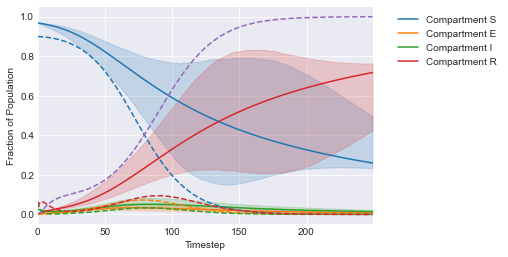

In [11]:
full_compartments = ['S'] + compartments
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[:,0], linestyle='--')
plt.show()


## Make restraints from reference trajectory


Using only first half of trajectory and use the R compartment in patch 0

In [82]:
npoints = 2
#prior = maxentep.Laplace(0.025)
prior = maxentep.EmptyPrior() # make empty to compare with regressed
restraints, plot_fxns = maxentep.traj_to_restraints(ref_traj[:125,:,:], [0, -1], npoints, prior, noise=0.01)

80 0.409913 0.40843403013821145
45 0.15348431 0.15218332994061026


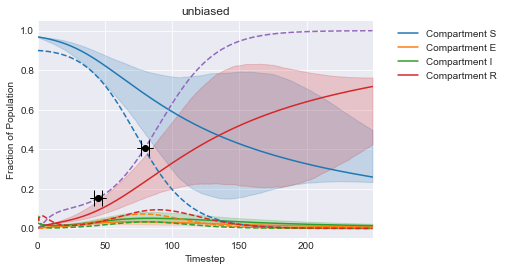

In [83]:
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.title('unbiased')
plt.plot(ref_traj[:,0], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(plt.gca(), 0)
plt.show()

In [84]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [85]:
history = me_model.fit(trajs, batch_size=8,epochs=32)

Epoch 1/32
1024/1024 [==============================] - 1s 656us/step - loss: 0.0149
Epoch 2/32
1024/1024 [==============================] - 1s 652us/step - loss: 0.0137
Epoch 3/32
1024/1024 [==============================] - 1s 667us/step - loss: 0.0130
Epoch 4/32
1024/1024 [==============================] - 1s 683us/step - loss: 0.0126
Epoch 5/32
1024/1024 [==============================] - 1s 651us/step - loss: 0.0121
Epoch 6/32
1024/1024 [==============================] - 1s 653us/step - loss: 0.0122
Epoch 7/32
1024/1024 [==============================] - 1s 703us/step - loss: 0.0126
Epoch 8/32
1024/1024 [==============================] - 1s 648us/step - loss: 0.0122
Epoch 9/32
1024/1024 [==============================] - 1s 648us/step - loss: 0.0118
Epoch 10/32
1024/1024 [==============================] - 1s 688us/step - loss: 0.0116
Epoch 11/32
1024/1024 [==============================] - 1s 671us/step - loss: 0.0126
Epoch 12/32
1024/1024 [==============================] - 1s 645

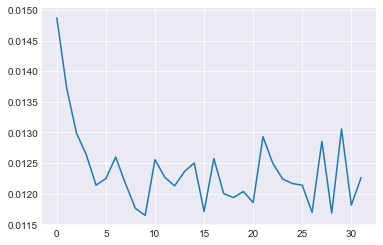

In [86]:
plt.plot(history.history['loss'])

In [87]:
me_model.lambdas

<tf.Variable 'maxent-lambda:0' shape=(2,) dtype=float32, numpy=array([-3.959028,  5.395409], dtype=float32)>

## Direct Regression of Model

In [88]:
T = tmat.sample(1)[0]
R = sample_rmat(1)[0]
s = make_starts(1)[0]
infect = maxentep.contact_infection_func(0.1,infections_compartments)
print(T.shape, R.shape, s.shape)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(s, R, T, infect, 250, agreement)

(3, 3) (4, 4) (4, 3)


In [89]:
rmodel.compile(optimizer=tf.keras.optimizers.Adam(0.01))
utraj = model.get_traj()
rmodel.fit(500)
rtraj = rmodel.get_traj()

500/500 [==============================] - 37s 73ms/step - loss: 0.0083 - output_2_loss: 0.0083


## Now visualize results

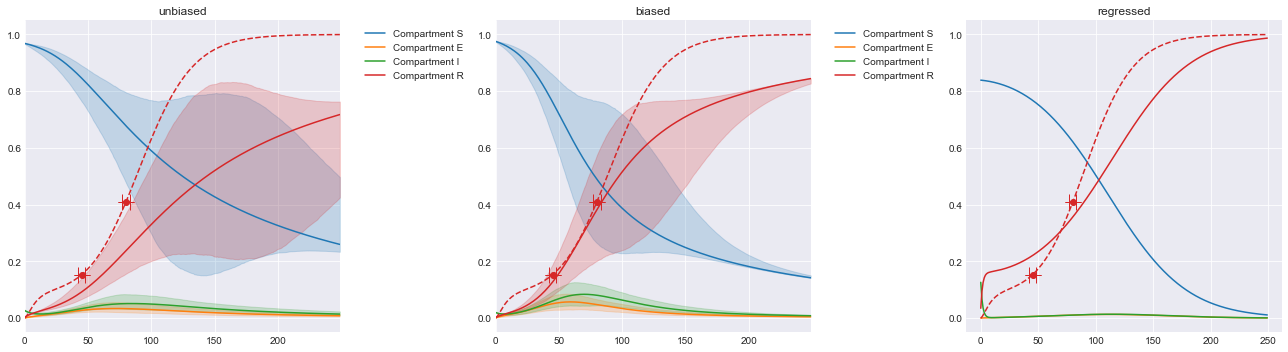

In [91]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
axs[0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, ax=axs[0])
axs[0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
for i,pf in enumerate(plot_fxns):
    pf(axs[0], me_model.lambdas[i], color='C3')

axs[1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[1])
axs[1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
for i,pf in enumerate(plot_fxns):
    pf(axs[1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[2].set_title('regressed')
axs[2].plot(rtraj[0,:,0,:])
axs[2].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
for i,pf in enumerate(plot_fxns):
    pf(axs[2], 1, color='C3')

plt.tight_layout()
plt.savefig('traj_match.png', dpi=300)
plt.show()